**Program**: 6_NSCH_AHR_Decision_Tree_Analysis<br>
**Class**: Fall 2025, Machine Learning, Project<br>
**Member**: Vanessa Thorsten<br>
**Description**: This program reads in the analysis dataset NSCH_AHR_state.csv, which provides data summarized at the state-level. Continuous variables are kept and standardized, and Decision Tree analysis is performed.<br>
<br>
**Outputs**: The following data visualizations are provided for the dataset:<br>
'Q6_heatmap_DT_features.png'<br>
'Q6_insurance_DT_CM.png'<br>
'Q6_insurance_DT_feature_importance.png'<br>
'Q6_insurance_DT_tree_plot.png'<br>
'Q6_insurance_DT_ROC.png'<br>
<br>
**Program History/Modifications**:<br>
10/10/2025    Initial Version

In [1]:
# Importing the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score, recall_score, classification_report
from sklearn.tree import plot_tree

from sklearn.inspection import PartialDependenceDisplay

In [2]:
#Combined state level data
df_state = pd.read_csv("NSCH_AHR_state.csv")
df_state.head()

,Unnamed: 0,STATE,nomChHlthSt_23_1.0_proportion,nomChHlthSt_23_2.0_proportion,PrevMed_23_1.0_proportion,PrevMed_23_2.0_proportion,K4Q01_1.0_proportion,K4Q01_2.0_proportion,smAdeqIns_23_1.0_proportion,smAdeqIns_23_2.0_proportion,...,immunizations,complete_hs,population_LT18,Poverty,primary_care_providers,public_health,support_engagement_annual,Uninsured,good_immun_cat,Region
0,0,AK,0.9245,0.0755,0.7562,0.2438,0.8580,0.1420,0.6341,0.3659,...,59.8,93.2,23.9,10.4,359.3,334.0,0.024,10.4,Low,West
1,1,AL,0.9022,0.0978,0.7939,0.2061,0.8134,0.1866,0.7404,0.2596,...,62.6,89.1,22.1,16.0,241.0,137.0,-0.745,8.5,Low,South
2,2,AR,0.9153,0.0847,0.7550,0.2450,0.7856,0.2144,0.6842,0.3158,...,62.0,89.3,23.0,16.3,241.4,128.0,-1.020,8.9,Low,South
3,3,AZ,0.8792,0.1208,0.7597,0.2403,0.7400,0.2600,0.6240,0.3760,...,62.9,89.4,21.3,12.6,258.2,84.0,0.125,9.9,Low,West
4,4,CA,0.8839,0.1161,0.7497,0.2503,0.7087,0.2913,0.7053,0.2947,...,59.8,84.8,21.7,12.0,229.7,173.0,0.199,6.4,Low,West


In [3]:
#Reverse coding for poverty and uninsured to positive
df_state['Above_Poverty'] = 100 - df_state['Poverty']
df_state['Insured'] = 100 - df_state['Uninsured']

In [4]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     51 non-null     int64  
 1   STATE                          51 non-null     object 
 2   nomChHlthSt_23_1.0_proportion  51 non-null     float64
 3   nomChHlthSt_23_2.0_proportion  51 non-null     float64
 4   PrevMed_23_1.0_proportion      51 non-null     float64
 5   PrevMed_23_2.0_proportion      51 non-null     float64
 6   K4Q01_1.0_proportion           51 non-null     float64
 7   K4Q01_2.0_proportion           51 non-null     float64
 8   smAdeqIns_23_1.0_proportion    51 non-null     float64
 9   smAdeqIns_23_2.0_proportion    51 non-null     float64
 10  healthy                        51 non-null     float64
 11  preventative_care              51 non-null     float64
 12  place_for_care                 51 non-null     float

In [5]:
# Using isna() to count NaNs in each column
column_nan_count_isna = df_state[['preventative_care', 'healthy', 'place_for_care', 
          'insurance','preventative_care',
          'complete_hs','population_LT18', 'Poverty','Above_Poverty',
          'primary_care_providers','public_health',
          'Uninsured', 'Insured','support_engagement_annual']].isna().sum()
print("NaN count per column using isna():") 
print(column_nan_count_isna)

NaN count per column using isna():
preventative_care            0
healthy                      0
place_for_care               0
insurance                    0
preventative_care            0
complete_hs                  0
population_LT18              0
Poverty                      0
Above_Poverty                0
primary_care_providers       0
public_health                0
Uninsured                    0
Insured                      0
support_engagement_annual    1
dtype: int64


In [6]:
print (df_state[df_state['support_engagement_annual'].isna()])

   Unnamed: 0 STATE  nomChHlthSt_23_1.0_proportion  \
7           7    DC                          0.907   

   nomChHlthSt_23_2.0_proportion  PrevMed_23_1.0_proportion  \
7                          0.093                       0.89   

   PrevMed_23_2.0_proportion  K4Q01_1.0_proportion  K4Q01_2.0_proportion  \
7                       0.11                0.7755                0.2245   

   smAdeqIns_23_1.0_proportion  smAdeqIns_23_2.0_proportion  ...  \
7                       0.6819                       0.3181  ...   

   population_LT18  Poverty  primary_care_providers  public_health  \
7             18.6     13.4                   553.6         1084.0   

   support_engagement_annual  Uninsured  good_immun_cat  Region  \
7                        NaN        2.7  Medium or high   South   

   Above_Poverty  Insured  
7           86.6     97.3  

[1 rows x 26 columns]


In [7]:
df_state[['healthy', 'place_for_care', 
          'insurance','preventative_care',
          'complete_hs','population_LT18', 'Poverty','Above_Poverty',
          'primary_care_providers','public_health',
          'Uninsured', 'Insured','support_engagement_annual']].describe().round(2)

,healthy,place_for_care,insurance,preventative_care,complete_hs,population_LT18,Poverty,Above_Poverty,primary_care_providers,public_health,Uninsured,Insured,support_engagement_annual
count,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,50.00
mean,90.79,79.92,66.73,80.27,91.21,21.64,12.59,87.41,301.36,154.20,7.18,92.82,-0.14
std,2.06,4.44,4.16,4.20,2.36,1.92,2.51,2.51,55.17,145.51,2.68,2.68,0.48
min,86.20,69.70,59.00,69.80,84.80,17.70,8.30,80.50,221.00,66.00,2.60,83.60,-1.02
25%,89.40,76.70,63.40,77.50,89.55,20.50,11.05,86.35,265.15,96.00,5.40,91.00,-0.56
50%,91.00,79.90,65.80,80.20,91.40,21.60,12.20,87.80,298.60,123.00,6.50,93.50,-0.02
75%,92.40,82.60,69.10,82.35,93.05,23.00,13.65,88.95,327.95,156.50,9.00,94.60,0.24
max,95.40,88.60,78.30,89.30,95.50,27.30,19.50,91.70,553.60,1084.00,16.40,97.40,0.75


In [8]:
# Replace missing support engagement with the median value for states
df_state['support_engagement_annual'] = df_state['support_engagement_annual'].fillna( df_state['support_engagement_annual'].median())

In [9]:
#Create outcome variable for states that are above the mean of states for 
#residents having any insurance (Insured from AHR) AND above the mean
#of states for children having continuous and adequate insurance (Insurance from NSCH)

insurance_bins = [0, 66.73, 99.99]
insurance_labels = [0,1]
df_state['insurance_categories'] = pd.cut(df_state['insurance'], 
                                        bins=insurance_bins, labels=insurance_labels, 
                                        right=False).astype(int)

df_state['insurance_categories'].value_counts()

insurance_categories
0    28
1    23
Name: count, dtype: int64

In [10]:
insure_bins = [0, 92.82, 99.99]
insure_labels = [0,1]
df_state['insured_categories'] = pd.cut(df_state['Insured'], 
                                        bins=insure_bins, labels=insure_labels, 
                                        right=False).astype(int)

df_state['insured_categories'].value_counts()

insured_categories
1    29
0    22
Name: count, dtype: int64

In [11]:
df_state['good_insure'] = ((df_state['insurance_categories']==1) &
                          (df_state['insured_categories']==1)).astype(int) 

df_state['good_insure'].value_counts()

good_insure
0    36
1    15
Name: count, dtype: int64

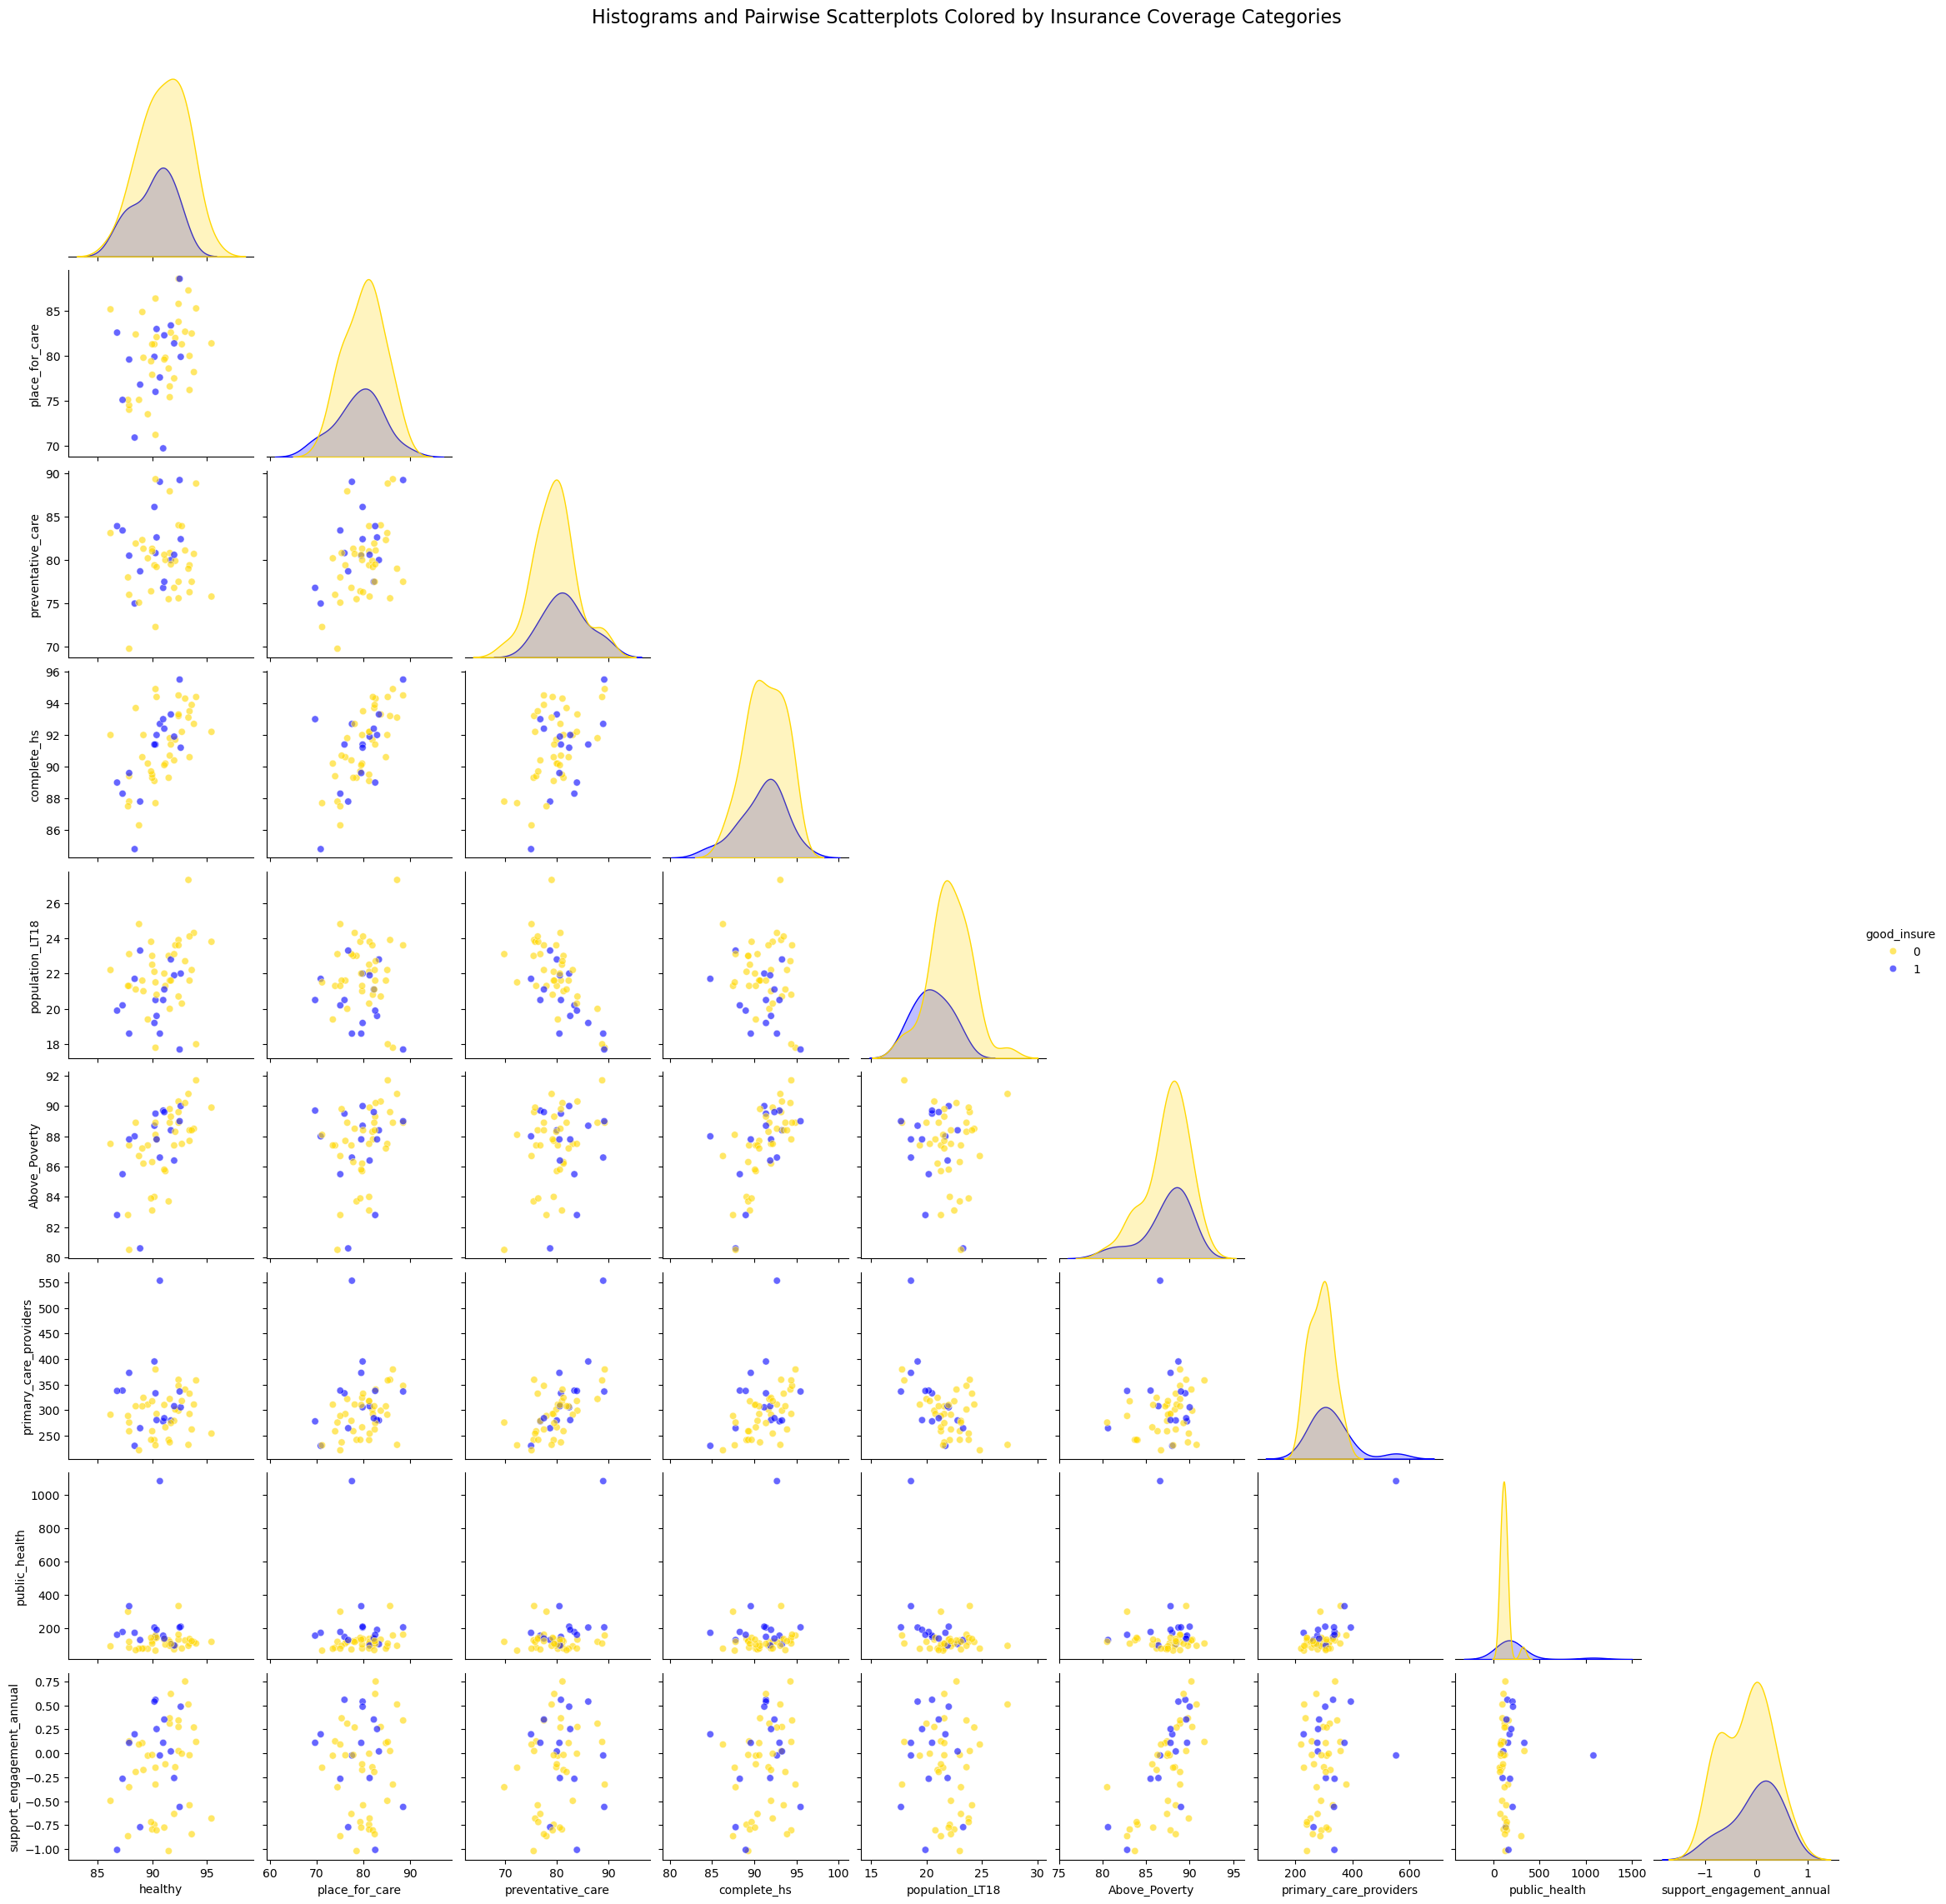

In [12]:
#Create pairplot with hue for good insurance and a subset of the variables

df_sub = df_state[['good_insure','healthy', 'place_for_care', 
          'preventative_care','complete_hs','population_LT18', 'Above_Poverty',
          'primary_care_providers','public_health', 'support_engagement_annual']]

sns.pairplot(df_sub, 
             hue='good_insure', 
             kind='scatter', 
             corner=True, 
             plot_kws={'alpha': 0.6},
             palette=['gold', 'blue'])

#title
plt.suptitle('Histograms and Pairwise Scatterplots Colored by Insurance Coverage Categories', fontsize=16, y=1.02)

# Show plot
plt.show()


In [13]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     51 non-null     int64  
 1   STATE                          51 non-null     object 
 2   nomChHlthSt_23_1.0_proportion  51 non-null     float64
 3   nomChHlthSt_23_2.0_proportion  51 non-null     float64
 4   PrevMed_23_1.0_proportion      51 non-null     float64
 5   PrevMed_23_2.0_proportion      51 non-null     float64
 6   K4Q01_1.0_proportion           51 non-null     float64
 7   K4Q01_2.0_proportion           51 non-null     float64
 8   smAdeqIns_23_1.0_proportion    51 non-null     float64
 9   smAdeqIns_23_2.0_proportion    51 non-null     float64
 10  healthy                        51 non-null     float64
 11  preventative_care              51 non-null     float64
 12  place_for_care                 51 non-null     float

In [14]:
# following are the features list
features_all = ['healthy', 'place_for_care', 
          'preventative_care','complete_hs','population_LT18', 'Above_Poverty',
          'primary_care_providers','public_health', 'support_engagement_annual']

target = 'good_insure'

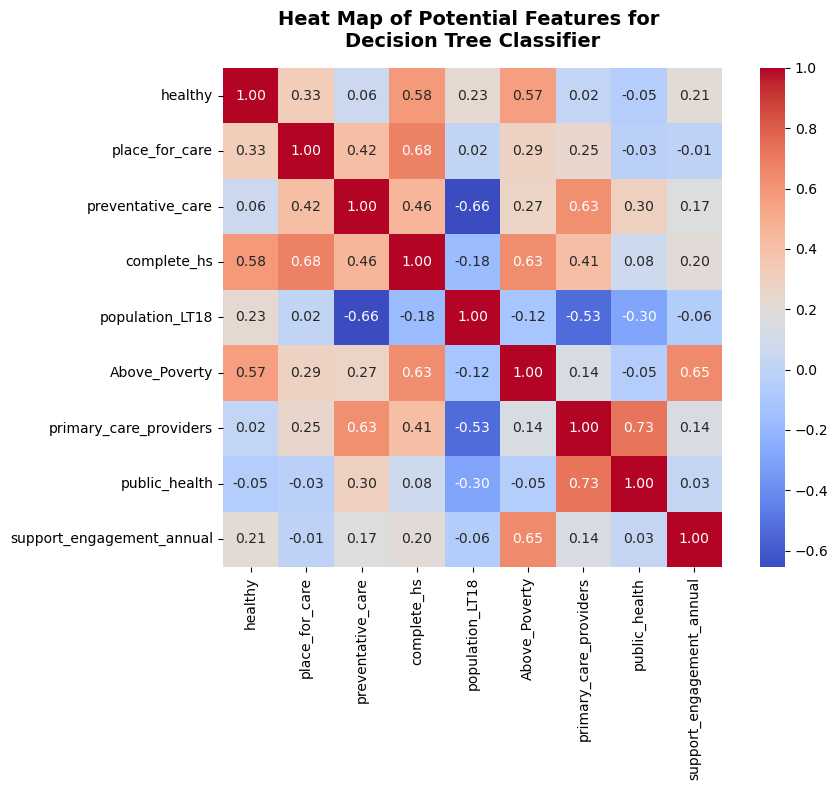

In [15]:
# Checking for multicollinearity between features

# Calculate correlation matrix
corr = df_state[features_all].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)

plt.title(f"Heat Map of Potential Features for \nDecision Tree Classifier",
          fontsize=14, weight='bold', pad=15)

# Save the plot
plt.tight_layout()
plt.savefig('Q6_heatmap_DT_features.png', dpi=300, bbox_inches='tight')

plt.show()


None of the variables are highly correlated (i.e. > 0.80). However, the number of primary care providers and public health spending are close at 0.73. Keep public health spending for the analysis based on the scatter plots above.

In [16]:
# Displaying the data before splitting
features = ['healthy', 'place_for_care', 
          'preventative_care','complete_hs','population_LT18', 'Above_Poverty',
          'public_health','support_engagement_annual']

display(df_state[features].head())
display(df_state[target].head())

,healthy,place_for_care,preventative_care,complete_hs,population_LT18,Above_Poverty,public_health,support_engagement_annual
0,92.4,85.8,75.6,93.2,23.9,89.6,334.0,0.024
1,90.2,81.3,79.4,89.1,22.1,84.0,137.0,-0.745
2,91.5,78.6,75.5,89.3,23.0,83.7,128.0,-1.020
3,87.9,74.0,76.0,89.4,21.3,87.4,84.0,0.125
4,88.4,70.9,75.0,84.8,21.7,88.0,173.0,0.199


0    0
1    0
2    0
3    0
4    1
Name: good_insure, dtype: int32

In [17]:
# Splitting the dataset into the Training set and Test set

X_train, X_test, y_train, y_test = train_test_split(df_state[features],df_state[target],test_size=0.3,random_state=4567)

In [18]:
# For training set
train_counts = y_train.value_counts()
train_percentages = y_train.value_counts(normalize=True) * 100
train_summary = pd.DataFrame({'Count': train_counts, 'Percentage': train_percentages.round(2)})
print("Training Set Class Distribution:")
display(train_summary)

# For test set
test_counts = y_test.value_counts()
test_percentages = y_test.value_counts(normalize=True) * 100
test_summary = pd.DataFrame({'Count': test_counts, 'Percentage': test_percentages.round(2)})
print("Test Set Class Distribution:")
display(test_summary)

Training Set Class Distribution:


,Count,Percentage
good_insure,,
0,25,71.43
1,10,28.57


Test Set Class Distribution:


,Count,Percentage
good_insure,,
0,11,68.75
1,5,31.25


In [19]:
# display the data after splitting

# Training set
display(pd.DataFrame(X_train).head())
display(pd.DataFrame(y_train).head())

# Test set
display(pd.DataFrame(X_test).head())
display(pd.DataFrame(y_test).head())
 

,healthy,place_for_care,preventative_care,complete_hs,population_LT18,Above_Poverty,public_health,support_engagement_annual
37,90.4,83.0,82.6,92.0,19.6,87.8,191.0,0.253
36,89.9,79.4,76.4,89.7,23.8,83.9,143.0,-0.718
49,86.8,82.6,83.9,89.0,19.9,82.8,161.0,-1.008
16,92.1,82.0,79.9,91.7,23.6,88.3,95.0,-0.145
32,87.8,75.1,78.0,87.5,21.3,82.8,300.0,-0.865


,good_insure
37,1
36,0
49,1
16,0
32,0


,healthy,place_for_care,preventative_care,complete_hs,population_LT18,Above_Poverty,public_health,support_engagement_annual
5,92.4,83.8,84.0,93.3,20.7,90.3,132.0,0.275
46,92.5,88.6,89.2,95.5,17.7,89.0,206.0,-0.560
22,89.2,79.8,81.3,92.0,21.0,86.2,79.0,-0.174
23,93.0,82.7,81.1,94.3,22.7,90.2,127.0,0.750
9,89.6,73.5,80.2,90.2,19.4,87.4,77.0,-0.025


,good_insure
5,0
46,1
22,0
23,0
9,0


In [20]:
# Do not need to scale the data for a decision tree analysis
# Displaying the training set

display(pd.DataFrame(X_train).head())

,healthy,place_for_care,preventative_care,complete_hs,population_LT18,Above_Poverty,public_health,support_engagement_annual
37,90.4,83.0,82.6,92.0,19.6,87.8,191.0,0.253
36,89.9,79.4,76.4,89.7,23.8,83.9,143.0,-0.718
49,86.8,82.6,83.9,89.0,19.9,82.8,161.0,-1.008
16,92.1,82.0,79.9,91.7,23.6,88.3,95.0,-0.145
32,87.8,75.1,78.0,87.5,21.3,82.8,300.0,-0.865


In [21]:
# Implementing decision tree classifier
# The decision tree is going to look for thresholds within the features that might
# be indicative of good insurance coverage then this will be the criterias for which 
#the splits will be set 
#look whichever split is going to maximize the information gain (or minimize the impurity)
#will be chosen as the split point.

classifier = DecisionTreeClassifier(random_state=4567) 
classifier.fit(X_train, y_train)

#X_train - the training features whose values may induce insurance coverage thresholds
#y_train - the coorresponding targer variable (0 or 1) for the training features

preds = classifier.predict(X_test) # makes predictions on the test set

### Confusion Matrix 
(notes from machine learning class)

A **confusion matrix** is a grid that shows how well your classifier is doing.

### Definitions:
- **TP (True Positive):** Model correctly predicted the class.
- **FP (False Positive):** Model incorrectly predicted this class.
- **FN (False Negative):** Model failed to predict this class.
- **TN (True Negative):** All other correctly rejected classes (not shown here in multi-class).

### Key Metrics:

These are common evaluation metrics used in classification tasks:

- **Accuracy** measures how often the classifier is correct:
 
  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  $$

- **Precision** measures how many selected items were relevant:

  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$

- **Recall** (Sensitivity) measures how many relevant items were selected:

  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$

- **F1 Score** is the harmonic mean of Precision and Recall:

  $$
  F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

The confusion matrix tells you **where your model messes up**. Accuracy is the **% of total correct**, but precision/recall tell you **how confident and complete** your predictions are per class.

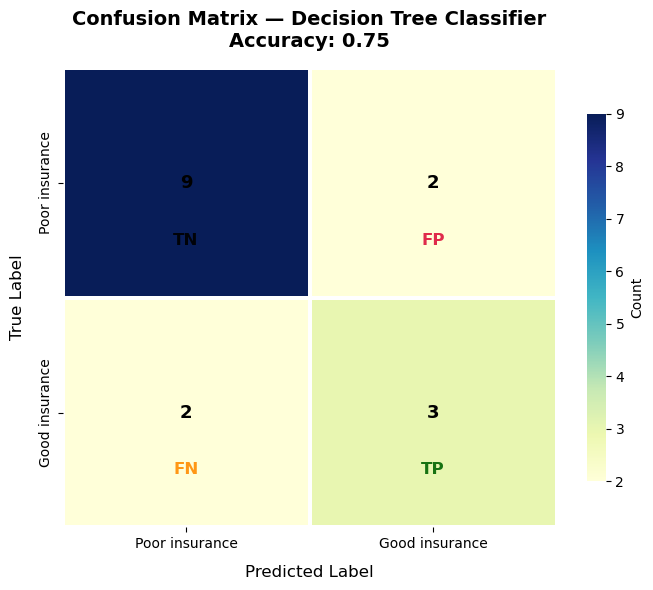

In [22]:
# Generating the confusion matrix

# Predictions
preds = classifier.predict(X_test)

# Compute confusion matrix and accuracy
cm = confusion_matrix(y_test, preds)
acc = accuracy_score(y_test, preds)

# Class labels
labels = ["Poor insurance", "Good insurance"]

# Plot setup
plt.figure(figsize=(7,6))
ax = sns.heatmap(cm, annot=True, fmt='d',
                 cmap='YlGnBu',
                 linewidths=1.5, linecolor='white',
                 xticklabels=labels, yticklabels=labels,
                 cbar_kws={'shrink':0.8, 'label':'Count'},
                 annot_kws={'size':13, 'weight':'bold', 'color':'black'})

plt.title(f"Confusion Matrix — Decision Tree Classifier\nAccuracy: {acc:.2f}",
          fontsize=14, weight='bold', pad=15)
plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
plt.ylabel("True Label", fontsize=12, labelpad=10)

# Label coordinates (slightly below numeric counts)
offset_y = 0.25  # small downward shift from center

# Overlay TN / FP / FN / TP *below* the numbers
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i == 0 and j == 0:
            label, color = "TN", "black"
        elif i == 0 and j == 1:
            label, color = "FP", "crimson"
        elif i == 1 and j == 0:
            label, color = "FN", "darkorange"
        else:
            label, color = "TP", "darkgreen"

        ax.text(j + 0.5, i + 0.5 + offset_y, label,
                color=color, fontsize=12, weight='bold',
                ha='center', va='center', alpha=0.9)

plt.tight_layout()

plt.savefig('Q6_insurance_DT_CM.png', dpi=300, bbox_inches='tight')

plt.show()

In [23]:
# Accuracy, F1 Score and Recall Score

# See final program for text on what these are

accuracy = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds)
recall = recall_score(y_test, preds)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Recall: {recall:.2f}')

Accuracy: 0.75
F1 Score: 0.60
Recall: 0.60


In [24]:
# Predict the test set probabilities of the positive class
y_pred_proba_dt = classifier.predict_proba(X_test)[:,1]
test_roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
# Print test_roc_auc
print('Test set ROC AUC score: {:.3f}'.format(test_roc_auc_dt))

Test set ROC AUC score: 0.709


In [25]:
print (classifier.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 4567, 'splitter': 'best'}


### Set the tree's hyperparameter grid
Set hyperparameters: max_depth = [8, 9, 10, None], criterion='gini', splitter='best',
'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1], random_state=4567

In [26]:
# Define params_dt
params_dt = {'max_depth': [8,9,10,None], 'criterion': ['gini'], 'splitter': ['best'], 
             'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1], 'random_state': [4567]}

### Search for the optimal decision tree

In [27]:
# Instantiate the decision tree
grid_dt = GridSearchCV(estimator=classifier,
                       param_grid=params_dt,
                       scoring='roc_auc',
                       cv=10,
                       n_jobs=-1)

### Evaluate the optimal tree

In [28]:
# Fit the dt
grid_dt.fit(X_train, y_train)

# Extract the best estimator
best_model_dt = grid_dt.best_estimator_

# Look at the best model hyperparameters
print (best_model_dt.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 4567, 'splitter': 'best'}


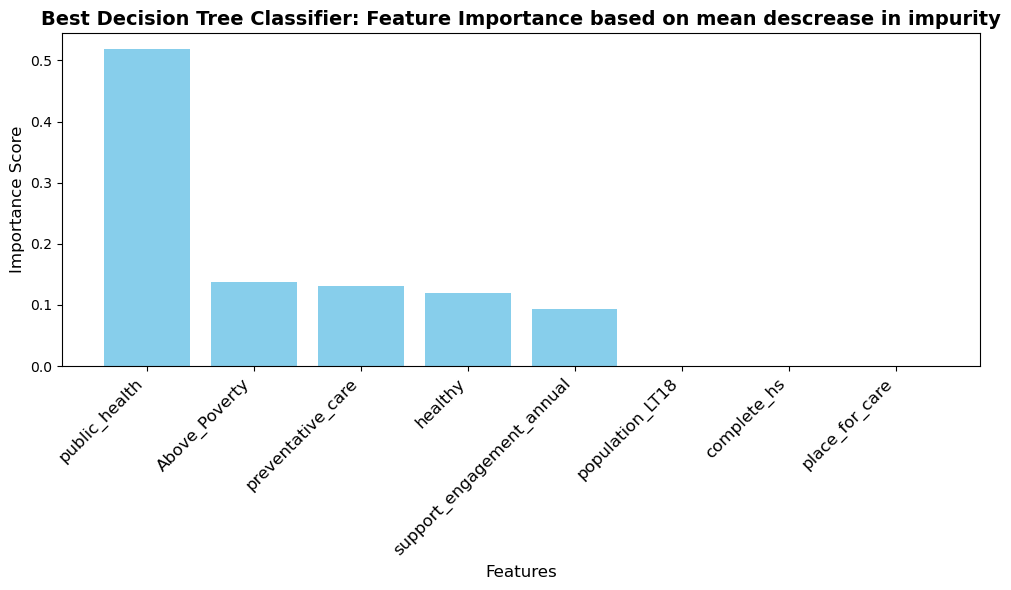

In [29]:
# visualizing the feature importance
importances = best_model_dt.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Best Decision Tree Classifier: Feature Importance based on mean descrease in impurity", fontsize=14, weight='bold')
plt.bar(range(X_train.shape[1]),importances[indices],align='center',color='skyblue')
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=45, ha='right', fontsize=12)
plt.xlabel("Features",fontsize=12)
plt.ylabel("Importance Score", fontsize=12)
plt.tight_layout()

plt.savefig('Q6_insurance_DT_feature_importance.png', dpi=300, bbox_inches='tight')

plt.show()

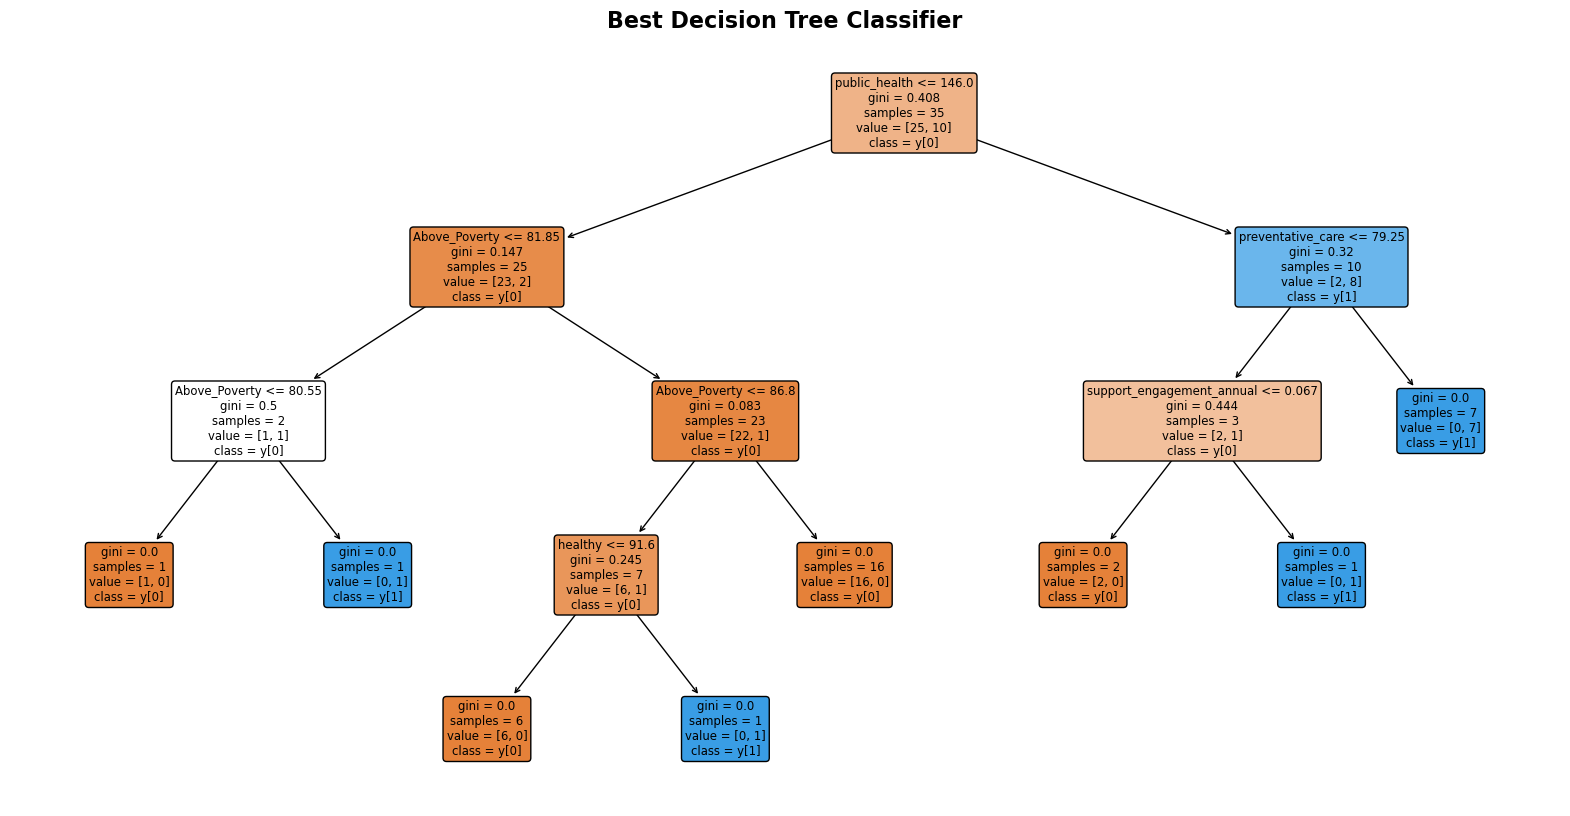

In [30]:
plt.figure(figsize=(20,10))
plot_tree(best_model_dt, feature_names=features, filled=True, rounded=True, class_names=True)
plt.title("Best Decision Tree Classifier", fontsize=16, weight='bold')

plt.savefig('Q6_insurance_DT_tree_plot.png', dpi=300, bbox_inches='tight')

plt.show()

In [31]:
# Predict the test set probabilities of the positive class
y_pred_proba_odt = best_model_dt.predict_proba(X_test)[:,1]
test_roc_auc_odt = roc_auc_score(y_test, y_pred_proba_odt)
# Print test_roc_auc
print('Test set ROC AUC score: {:.3f}'.format(test_roc_auc_odt))

Test set ROC AUC score: 0.709


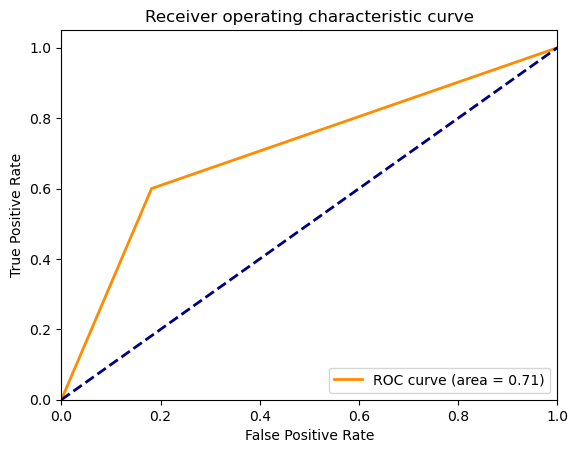

In [32]:
## ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_odt)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_roc_auc_odt)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")

plt.savefig('Q6_insurance_DT_ROC.png', dpi=300, bbox_inches='tight')

plt.show()

In [33]:
#For trees, a record is associated with a leaf, and the class with the highest probability 
#  is assigned as the predicted class.
y_pred_prob_odt = best_model_dt.predict(X_test)
test_accuracy_odt = accuracy_score(y_test, y_pred_prob_odt)
test_accuracy_odt

0.75

In [34]:
# [true negatives,  false positives
#  false negatives, true positives]

# Sensitivity = true positives / (true positives + false negatives)
# Specificity = true negatives / (true negatives + false positives)

# Precision = true positives / (true positives + false positives)
#  Also know as Positive Predictive Value

print(confusion_matrix(y_test, y_pred_prob_odt))
print("")
print(y_test.value_counts())

[[9 2]
 [2 3]]

good_insure
0    11
1     5
Name: count, dtype: int64


In [35]:
#Positive Predictive Value (focusing on positive event) = 'precision' within the '1' row.
#Sensitivity (focusing on positive event) = 'recall' within the '1' row.
#Specificity (focusing on positive event) = 'recall' within the '0' row.
#Specificity (focusing on negative event) = Sensitivity (focusing on positive event)

#f1-score = 2*(precision*recall)/(precision + recall)  #harmonic mean of precision and recall.

#support is the number of occurrences of each class in y_test

print(classification_report(y_test, y_pred_prob_odt))
print(np.mean(y_test))
print(1-np.mean(y_test))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.60      0.60      0.60         5

    accuracy                           0.75        16
   macro avg       0.71      0.71      0.71        16
weighted avg       0.75      0.75      0.75        16

0.3125
0.6875


### Partial dependence plots 
Look for the directionality of the results.

Partial dependence plots show the dependence between the target function and a set of ‘target’ features, marginalizing over the values of all other features (the complement features). 

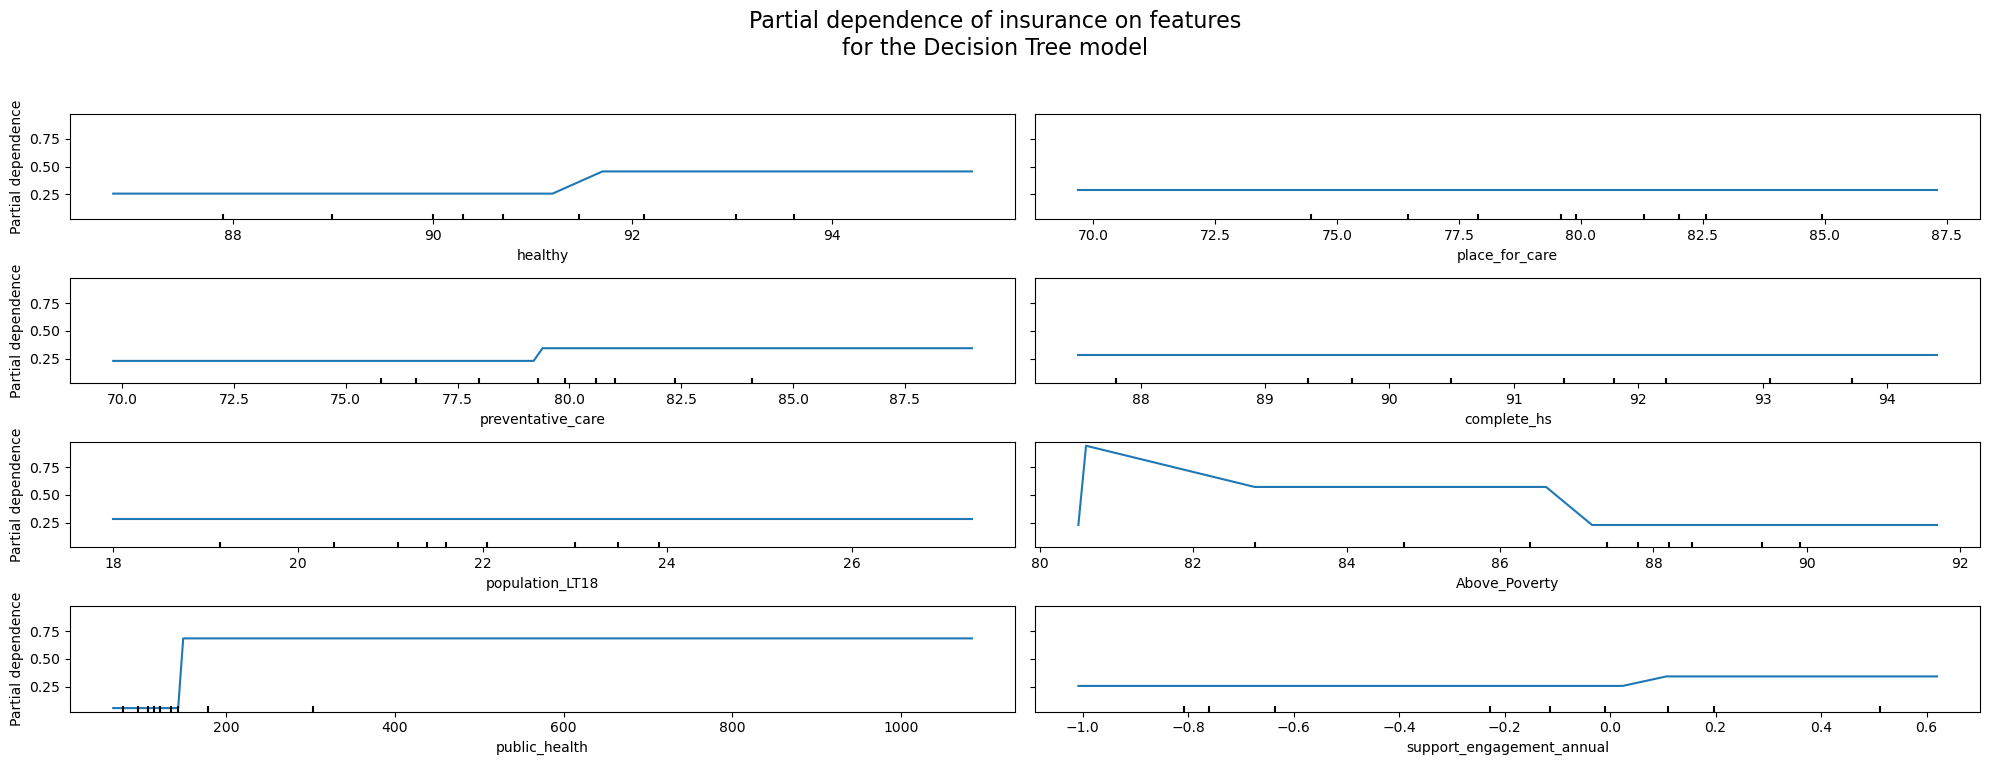

In [36]:
features=['healthy', 'place_for_care', 
          'preventative_care','complete_hs','population_LT18', 'Above_Poverty',
          'public_health','support_engagement_annual']

# Create PDP with a grid layout and larger figure size
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 8))  # 2 rows, 5 columns
PartialDependenceDisplay.from_estimator(best_model_dt, X_train, features, ax=ax)

# Set title and adjust layout
fig.suptitle('Partial dependence of insurance on features\nfor the Decision Tree model', fontsize=16)
fig.subplots_adjust(wspace=0.3, hspace=0.4)  # spacing between plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave space for the suptitle
plt.show()